In [8]:
from Bio import SeqIO, SeqUtils
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")

def GC_content_plot(fastq, base_qual=False, read_qual=False, min_read_len=1):
    GC = []
    filtered_reads = 0
    for record in tqdm_notebook(SeqIO.parse(fastq, "fastq")):
        
        if (read_qual) & (np.mean(record.letter_annotations['phred_quality'])<read_qual):
            filtered_reads+=1
            continue
        
        if (base_qual):
            quals = record.letter_annotations['phred_quality']
            seq = ''.join([char for i, char in enumerate(record.seq) if quals[i] > base_qual])
        else:
            seq=record.seq
        
        if len(seq) < min_read_len: 
            continue
        GC.append(SeqUtils.GC(seq))
    
    sorted_vals, counts = np.unique(GC, return_counts=True)
    plt.figure(figsize=[12, 12])
    plt.scatter(sorted_vals, counts, color='red', 
                label='Mean %GC content = {}\nRead quality threshold = {}\nBp quality threshold = {}'.\
                format(np.round(np.mean(GC), 2), read_qual, base_qual)+\
                '\nMinimum read length = {}'.format(min_read_len))
    plt.legend(prop={'size': 12})
    
    plt.grid()
    plt.xlabel('%GC content in a read')
    plt.ylabel('Number of reads')
    ax = plt.gca()
    ax.set_xticks(list(range(0, 101, 10)))
    ax.set_xlim(-5, 105)
    try:
        plt.title('%GC content of reads in {} file'.format(fastq[-fastq[::-1].index('/'):])) 
    except:
        plt.title('%GC content of reads in {} file'.format(fastq))
    plt.show()
    print(filtered_reads)
    return sorted_vals, counts

def filename(path):
    try:
        fname = path[-path[::-1].index('/'):]
        return fname
    except:
        return path
    
def score_to_prob(score):
    return 10**(-score/10)

def error_plot(fastq, whisker_mult=3, merge=False, merge_start=9, merge_step=5, tick_step=2):
    
    means_by_position = {}
    variance_by_position = {}
    
    for n, record in tqdm_notebook(enumerate(SeqIO.parse(fastq, "fastq"))):
        for pos, score in enumerate(map(score_to_prob, record.letter_annotations['phred_quality'])):
            if pos not in means_by_position.keys():
                means_by_position[pos] = score
                variance_by_position[pos] = 0
            else:
                curr_mean = means_by_position[pos]
                curr_var = variance_by_position[pos]
                means_by_position[pos] = curr_mean + (score-curr_mean)/(n+1)
                variance_by_position[pos] = curr_var + curr_mean**2 - means_by_position[pos]**2 +\
                                            (score**2-curr_var-curr_mean**2)/(n+1)
            
    positions, means = zip(*means_by_position.items())
    _, variances = zip(*variance_by_position.items())
    stds = whisker_mult*np.sqrt(variances)
    fig, ax = plt.subplots(figsize=[14, 10])
    fig.suptitle('Sequencing error probability across all bases\n{} file'.format(filename(fastq)))
    ax.set_xlabel('Position')
    ax.set_ylabel('Probability error')
    if merge:
        nm = list(means[:merge_start])
        nstds = list(stds[:merge_start])
        npos = list(positions[:merge_start])
        ticks = list(map(str, range(1, merge_start+1)))
        for d, i in enumerate(range(merge_start, len(means), merge_step)):
            nm.append(np.mean(means[i:i+merge_step]))
            nstds.append(np.mean(means[i:i+merge_step]))
            npos.append(npos[-1]+1)
            if d%tick_step != 0:
                ticks.append('{}-{}'.format(i+1, i+merge_step))
            else:
                ticks.append('')
        means = nm
        stds = nstds
        positions = npos
        ax.set_xticks(positions)
        ax.set_xticklabels(ticks, minor=False)
    ax.errorbar(positions, means, yerr=stds, color='red', linestyle='--', alpha=0.8)
    return means, stds

def naive_error(fastq, whisker_mult=3):
    
    from collections import defaultdict
    errors_by_position = defaultdict(list)
    for record in SeqIO.parse(fastq, 'fastq'):
        for pos, score in enumerate(map(score_to_prob, record.letter_annotations['phred_quality'])):
            errors_by_position[pos].append(score)
            
    positions, errors = zip(*errors_by_position.items())
    means = [np.mean(x) for x in errors]
    stds = [whisker_mult*np.std(x) for x in errors]
    fig, ax = plt.subplots(figsize=[14, 10])
    ax.errorbar(positions, means, yerr=stds, color='red', linestyle='--', alpha=0.8)
    return means, stds

def kmer_generator(k, alphabet=['A', 'C', 'G', 'T']):
    from itertools import product
    return [''.join(kmer) for kmer in product(alphabet, repeat=k)]

def kmer_spectres(fastq, k, bins_one_plot=8):
    counter = {key: 0 for key in kmer_generator(k)}
    masked = 0
    for record in tqdm_notebook(SeqIO.parse(fastq, "fastq")):
        for i in range(len(record.seq)-k+1):
            try:
                counter[record.seq[i:i+k]]+=1
            except:
                masked+=1
                continue
    plot_num = (len(counter)//bins_one_plot)+bool(len(counter)%bins_one_plot)
    names, counts = zip(*counter.items())
    fig, axarr = plt.subplots(plot_num, figsize=[2*bins_one_plot, 1.5*plot_num])
    j = 0
    ylim = 1.05*max(counts)
    for i in range(0, len(names), bins_one_plot):
        axarr[j].bar(names[i:i+bins_one_plot], counts[i:i+bins_one_plot])
        axarr[j].set_ylim(top=ylim)
        axarr[j].yaxis.grid()
        j += 1
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle('K-mer spectra, {} file\n  k = {}\nNumber of unidentified k-mers = {}'.\
                 format(filename(fastq),k, masked))
    return counter

# Tests

In [2]:
test_file = 'Data/Assignment_1/test.fastq'

Function **GC_content_plot** computes empirical distribution of %gc content in reads of an input .fastq file. Thresholds can be specified for both single nucleotide quality and mean read quality.

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

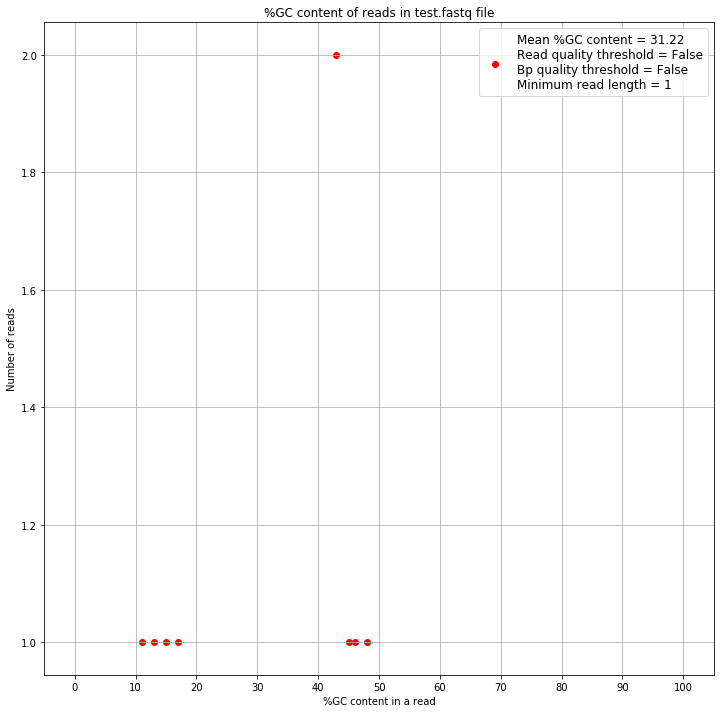

0


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

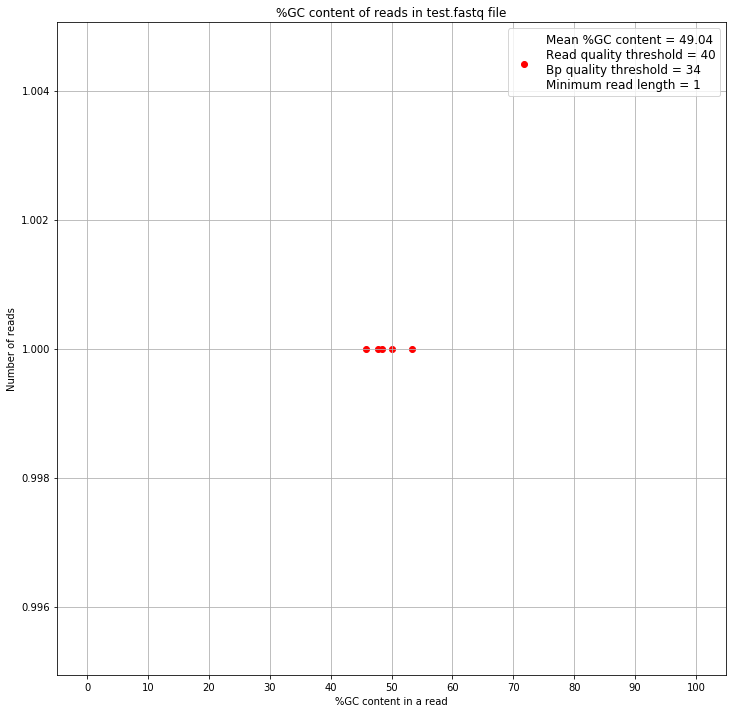

0


In [3]:
_ = GC_content_plot(test_file)
_ = GC_content_plot(test_file, base_qual=34, read_qual=40)

Function **error_plot** computes mean and standard deviation of sequencing error probabilities for a given position in a read, recursive formula is used to compute both mean and standard deviation. Then an error bar plot is constructed. 

Iterative algorithm shows similar resulst with the naive version of an algorithm, that collects error probabilities for all the reads and then computes mean and standeard deviation. Thus the naive algorithm works correctly.

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Means obtained via algorithm that updates means iteratively:

(0.0005011872336272725, 0.00022403118716058938, 0.00022718479594049102, 0.00022345570819261589) 

Means obtained via straightforward algorithm:

[0.00050118723362727253, 0.00022403118716058938, 0.00022718479594049096, 0.00022345570819261591] 

Standard deviations obtained via algorithm that updates them iteratively:

[ 0.00074374  0.00073555  0.00074524  0.00074195] 

Standard deviation obtained via straightforward algorithm:

[0.00074373747175770838, 0.00073554722398308276, 0.00074523844619881039, 0.00074195401056005334]


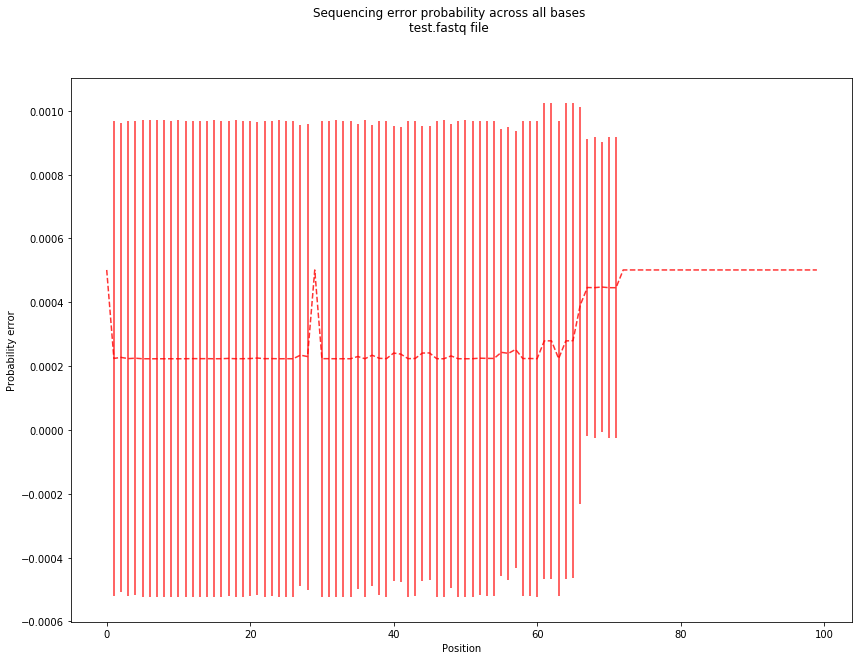

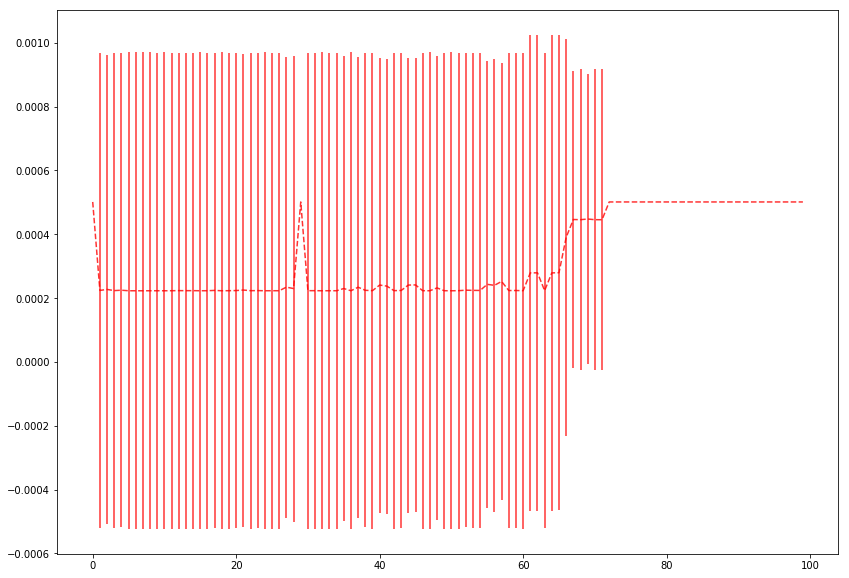

In [9]:
means, stds = error_plot(test_file)
means_n, stds_n = naive_error(test_file)
print('Means obtained via algorithm that updates means iteratively:\n')
print(means[:4], '\n')
print('Means obtained via straightforward algorithm:\n')
print(means_n[:4], '\n')
print('Standard deviations obtained via algorithm that updates them iteratively:\n')
print(stds[1:5], '\n')
print('Standard deviation obtained via straightforward algorithm:\n')
print(stds_n[1:5])

Also **error_plot** allows for a more compact visualization by grouping statistics from several bases as it is shown below:

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

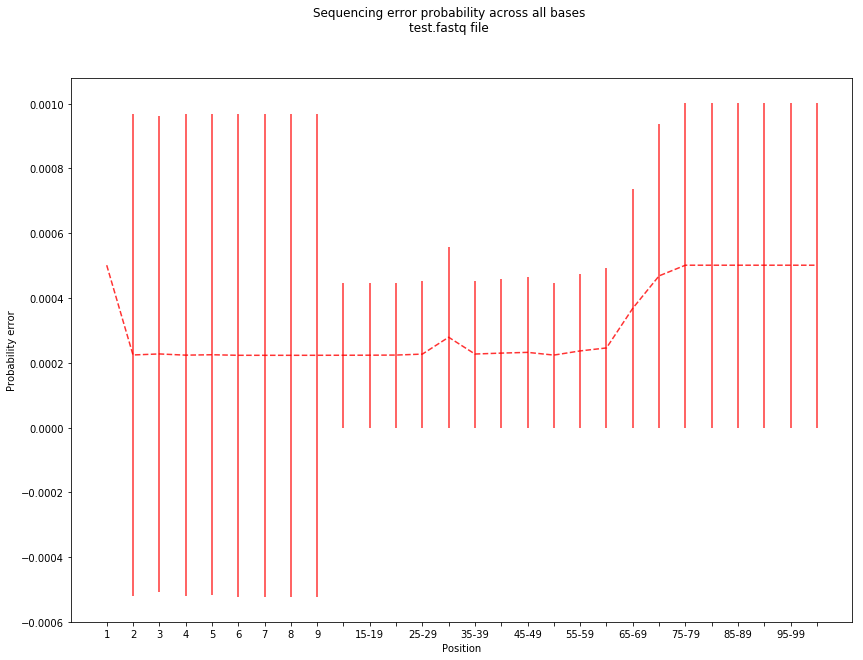

In [10]:
means, stds = error_plot(test_file, merge=True)

Function **kmer_spectres** plots k-mer spectra of an input .fastq file.

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

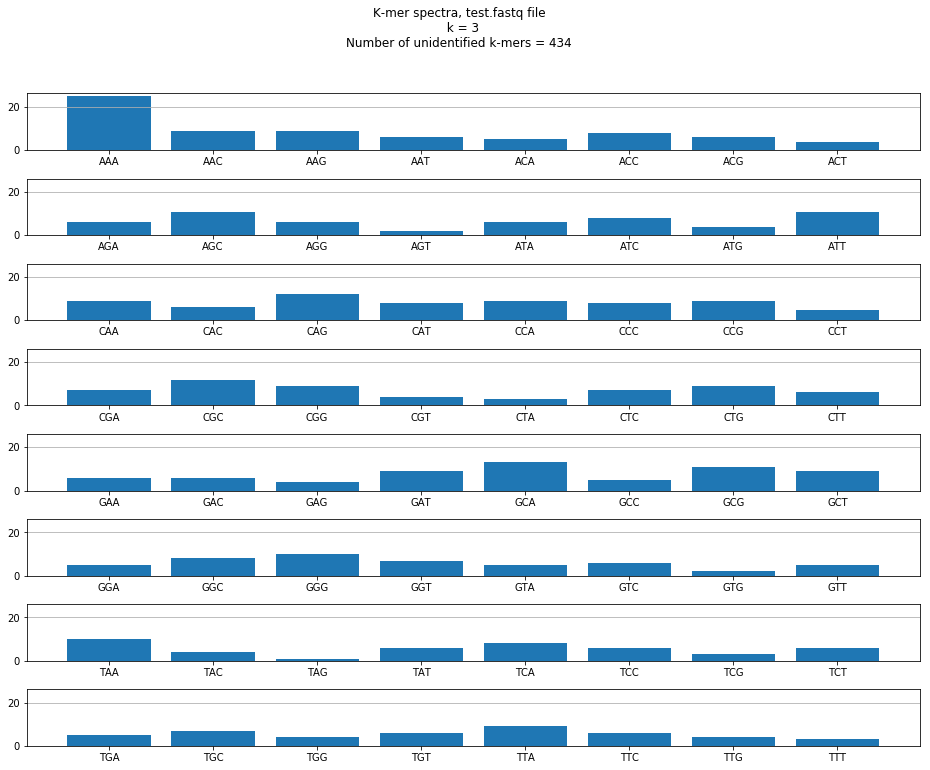

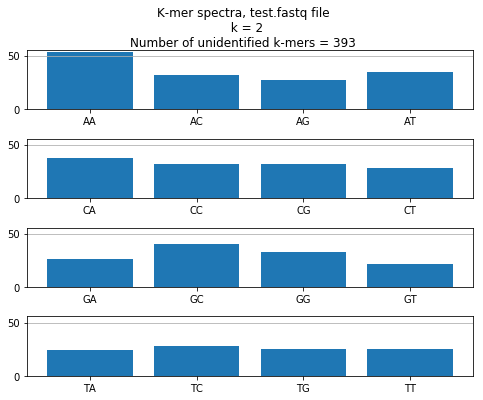

In [11]:
_ = kmer_spectres(test_file, k=3, bins_one_plot=8)
_ = kmer_spectres(test_file, k=2, bins_one_plot=4)

# Running on the data

Now, after the testing is done, let's run algorithms on a real data.

In [4]:
R1 = 'Data/Assignment_1/frag.R1.fastq'
R2 = 'Data/Assignment_1/frag.R2.fastq'

As it is evident from the plots below, both files with paired reads have similar %GC content distributions, but the distibution of R2 has longer left tail. GC content of those reads is high with the mean around 72.5. 

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

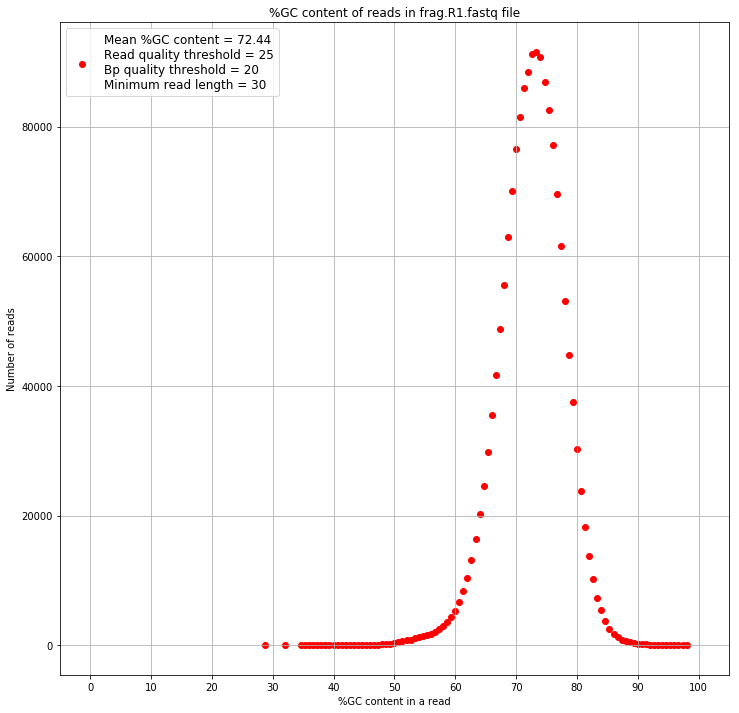

0


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

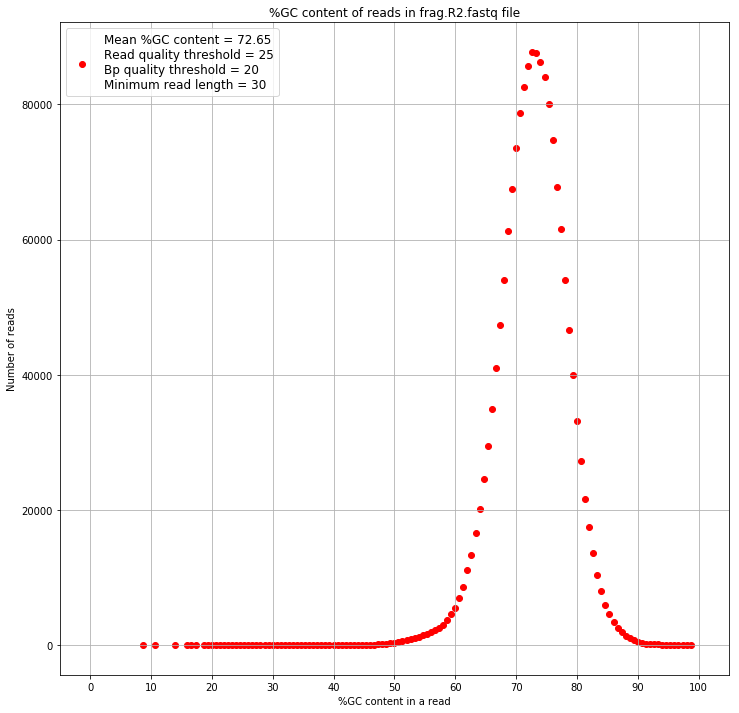

0


In [6]:
_ = GC_content_plot(R1, base_qual=20, read_qual=25, min_read_len=30)
_ = GC_content_plot(R2, base_qual=20, read_qual=25, min_read_len=30)

Error plots below show that sequencing error probability grows the farther the nucleotide from the start of the read. File *frag.R2.fastq* is of a lower quality than *frag.R1.fastq*: quality of its reads drops faster and has larger standard deviation.

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

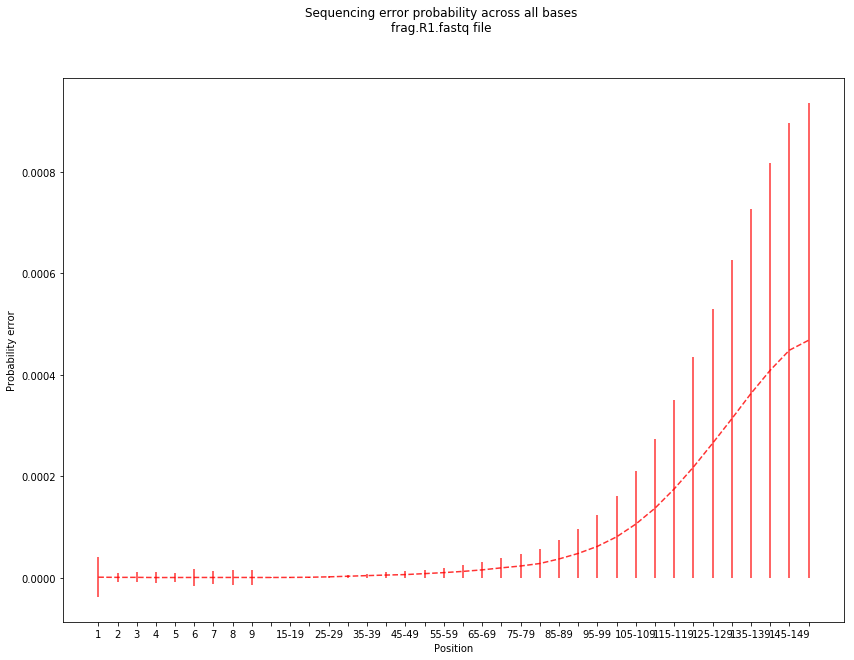

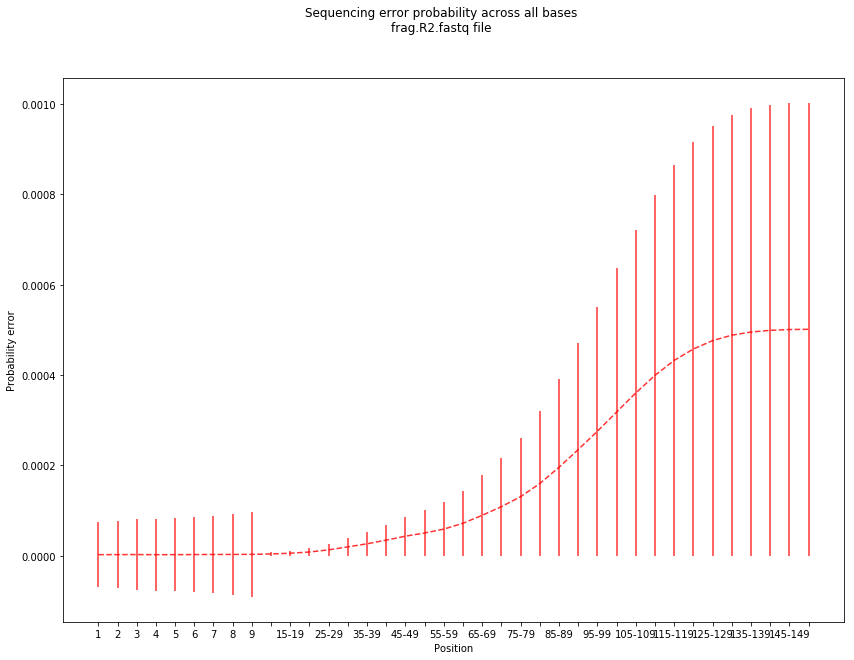

In [12]:
_ = error_plot(R1, merge=True)
_ = error_plot(R2, merge=True)

As expected, 3-mer spectra of two files are similar. 3-mers containing cytosine and guanine prevail, which corresponds to the previous finding that GC-content of the given reads is high.

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

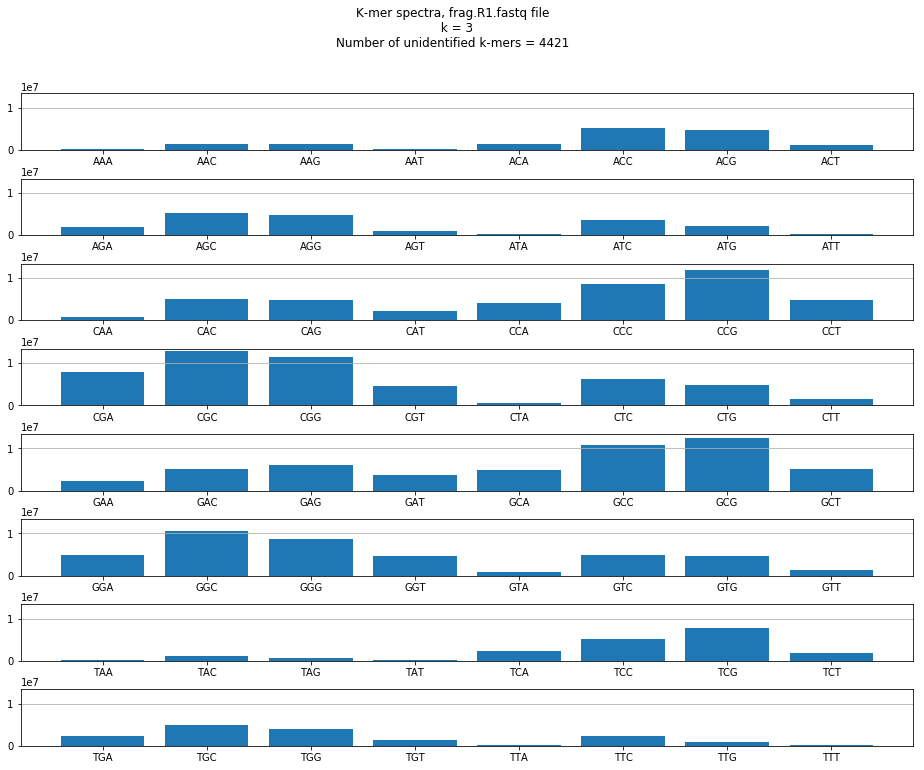

In [13]:
_ = kmer_spectres(R1, 3, 8)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

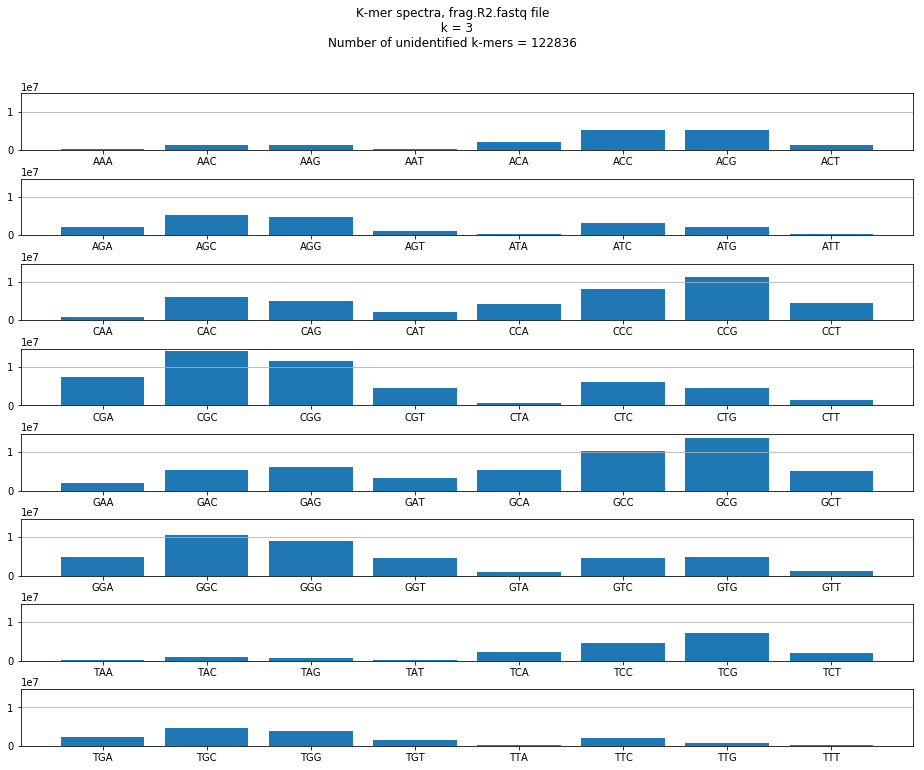

In [15]:
_ = kmer_spectres(R2, 3, 8)

# FastQC

FastQC version 0.11.7 was used to compute statistics similar to the above.

No sequences were flagged as poor quality.

Quality plots:

**frag.R1.fastq**

![title](Images/frag.R1.qual.png)

**frag.R2.fastq**

![title](Images/frag.R2.qual.png)

GC content plots:

**frag.R1.fastq**

![title](Images/frag.R1.GC.png)

**frag.R2.fastq**

![title](Images/frag.R2.GC.png)


No overrepresented sequences were found in the files.

My results are consistent with FastQC ones.